In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_json(file_path):
    data = []
    with open(file_path, 'r') as f:
        line = f.readline()
        while line:
            data.append(json.loads(line))
            line = f.readline()
    return pd.DataFrame(data)


def calculate_overall_statistics(df):
    total_time = df['total_time']
    percentiles = np.percentile(total_time, [50, 75, 85, 90, 95, 99])
    
    overall_stats = {
        'avg': total_time.mean(),
        'max': total_time.max(),
        'p50': percentiles[0],
        'p75': percentiles[1],
        'p85': percentiles[2],
        'p90': percentiles[3],
        'p95': percentiles[4],
        'p99': percentiles[5]
    }
    
    return pd.DataFrame([overall_stats])


def calculate_statistics(df):
    bin_size = 5000000
    df = df.copy()
    df.loc[:, 'gas_used_range'] = pd.cut(df['gas_used'], bins=np.arange(0, df['gas_used'].max() + bin_size, bin_size))
    
    grouped = df.groupby('gas_used_range', observed=False)['total_time']

    def under_1_sec_percentage(x):
        return (x < 1).sum() / x.count() * 100

    def under_2_sec_percentage(x):
        return (x < 2).sum() / x.count() * 100

    distribution = grouped.agg(
        avg='mean',
        max='max',
        p50=lambda x: np.percentile(x, 50),
        p75=lambda x: np.percentile(x, 75),
        p85=lambda x: np.percentile(x, 85),
        p90=lambda x: np.percentile(x, 90),
        p95=lambda x: np.percentile(x, 95),
        p99=lambda x: np.percentile(x, 99),
        count='count',
        under_1s_rate=under_1_sec_percentage,
        under_2s_rate=under_2_sec_percentage,
    ).reset_index()

    overall_under_1_sec_percentage = under_1_sec_percentage(df['total_time'])
    overall_under_2_sec_percentage = under_2_sec_percentage(df['total_time'])

    overall_stats = calculate_overall_statistics(df).iloc[0]
    max_gas_used = int((df['gas_used'].max() + bin_size) / bin_size) * bin_size 
    overall_stats['gas_used_range'] = f"(0, {max_gas_used}]"
    overall_stats['count'] = df['total_time'].count()
    overall_stats['under_1s_rate'] = overall_under_1_sec_percentage
    overall_stats['under_2s_rate'] = overall_under_2_sec_percentage

    distribution = pd.concat([distribution, pd.DataFrame([overall_stats])], ignore_index=True)

    return distribution, overall_under_1_sec_percentage, grouped


def plot_histogram(grouped, gas_range):
    total_times = grouped.get_group(gas_range)

    plt.figure(figsize=(10, 6))
    plt.hist(total_times, bins=50, edgecolor='black')
    plt.title(f'Histogram of total_time for gas_used_range {gas_range}')
    plt.xlabel('total_time')
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

In [2]:
df_archive = load_json('base_archive_high_cache.json')
df_full = load_json('base_full_high_cache.json')
df_reth = load_json('base_reth_maxperf.json')

common_blocks = set(df_archive['block_number']).intersection(df_full['block_number']).intersection(df_reth['block_number'])

df_archive = df_archive[df_archive['block_number'].isin(common_blocks)]
df_full = df_full[df_full['block_number'].isin(common_blocks)]
df_reth = df_reth[df_reth['block_number'].isin(common_blocks)]

distribution_archive, under_1_sec_archive, grouped_archive = calculate_statistics(df_archive)
distribution_full, under_1_sec_full, grouped_full = calculate_statistics(df_full)
distribution_reth, under_1_sec_reth, grouped_reth = calculate_statistics(df_reth)

In [3]:
print(f"op-geth archive node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_archive:.4f}% is under 1s")
distribution_archive

op-geth archive node | base-mainnet 5492540 ~ 7201474 | 98.7778% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.042188,8.828,0.020,0.028,0.035,0.041,0.05400,0.76990,1560011,99.167826,99.763271
1,"(5000000, 10000000]",0.385224,10.402,0.163,0.557,0.731,0.784,0.89900,2.67476,38329,96.892692,98.737249
2,"(10000000, 15000000]",0.309952,9.506,0.159,0.237,0.616,0.726,0.84535,2.14135,17894,96.965463,98.871130
3,"(15000000, 20000000]",0.437804,10.289,0.294,0.370,0.427,0.729,1.46700,3.05188,20479,90.912642,97.348503
4,"(20000000, 25000000]",0.575704,9.974,0.458,0.522,0.609,0.847,1.68320,3.79772,20817,90.560600,97.050488
5,"(25000000, 30000000]",0.617403,9.851,0.510,0.559,0.614,0.674,0.86800,4.61496,51405,95.438187,97.502189
6,"(0, 30000000]",0.081228,10.402,0.022,0.032,0.047,0.091,0.47500,1.21200,1708935,98.777777,99.600921


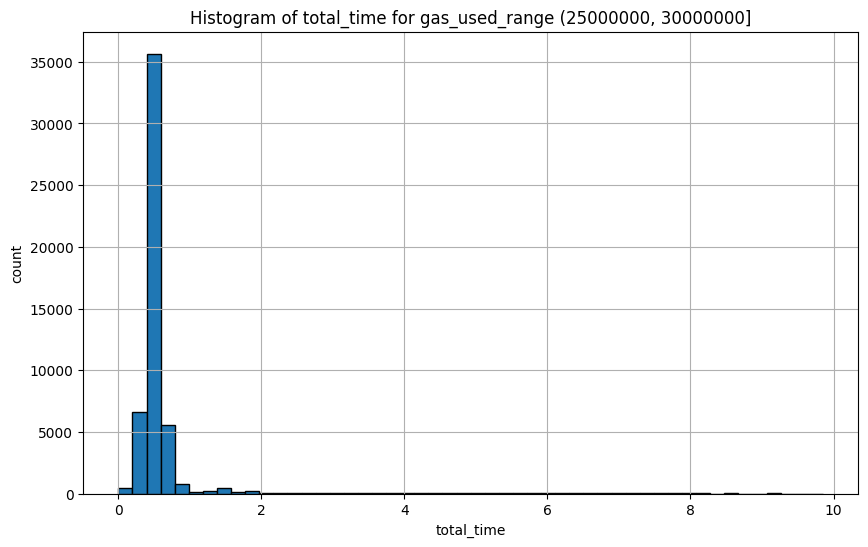

In [4]:
plot_histogram(grouped_archive, distribution_archive.loc[5, 'gas_used_range'])

In [5]:
print(f"op-geth full node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_full:.4f}% is under 1s")
distribution_full

op-geth full node | base-mainnet 5492540 ~ 7201474 | 99.8467% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.021889,2.588,0.018,0.026,0.03100,0.036,0.044,0.06800,1560011,99.999423,99.999936
1,"(5000000, 10000000]",0.238040,5.854,0.119,0.369,0.48800,0.526,0.570,0.82100,38329,99.569517,99.866941
2,"(10000000, 15000000]",0.206315,4.818,0.145,0.181,0.38605,0.493,0.558,0.75814,17894,99.793227,99.932938
3,"(15000000, 20000000]",0.283780,3.900,0.222,0.248,0.28000,0.469,0.945,1.39600,20479,96.249817,99.965819
4,"(20000000, 25000000]",0.357587,5.139,0.299,0.334,0.37200,0.552,0.976,1.36600,20817,95.724648,99.923140
5,"(25000000, 30000000]",0.361782,5.154,0.330,0.357,0.38600,0.427,0.632,1.10192,51405,98.539053,99.893007
6,"(0, 30000000]",0.046120,5.854,0.019,0.029,0.04000,0.057,0.267,0.46400,1708935,99.846688,99.991691


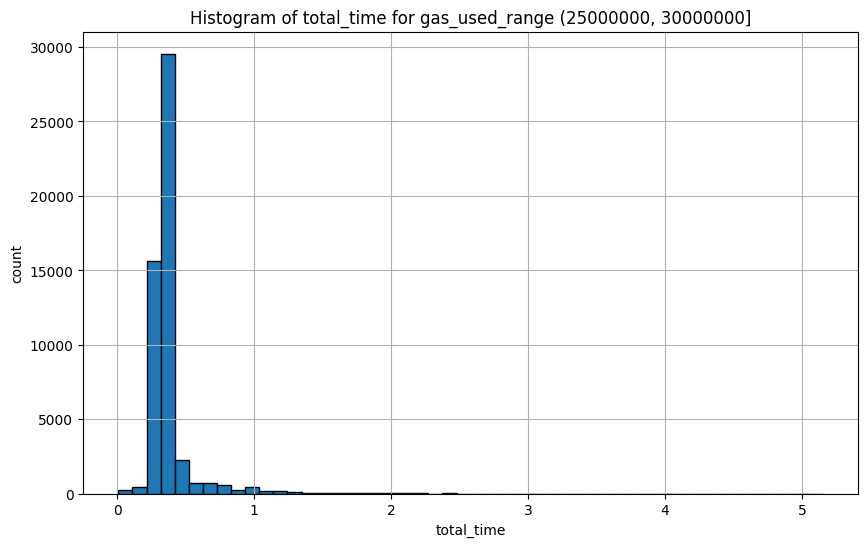

In [6]:
plot_histogram(grouped_full, distribution_full.loc[5, 'gas_used_range'])

In [7]:
print(f"op-reth archive node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_reth:.4f}% is under 1s")
distribution_reth

op-reth archive node | base-mainnet 5492540 ~ 7201474 | 99.7766% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.041262,0.843,0.038,0.051,0.059,0.0660,0.0750,0.09800,1560011,100.000000,100.000000
1,"(5000000, 10000000]",0.311898,1.737,0.153,0.512,0.604,0.6872,0.7860,0.87500,38329,99.926948,100.000000
2,"(10000000, 15000000]",0.234678,1.470,0.123,0.298,0.550,0.6620,0.7160,0.88407,17894,99.731754,100.000000
3,"(15000000, 20000000]",0.351376,1.985,0.324,0.456,0.508,0.5670,1.0350,1.51500,20479,93.642268,100.000000
4,"(20000000, 25000000]",0.503560,2.469,0.530,0.611,0.676,0.7290,1.1610,1.53584,20817,92.842388,99.947159
5,"(25000000, 30000000]",0.568855,5.945,0.580,0.664,0.702,0.7280,0.7728,1.33096,51405,98.151931,99.961093
6,"(0, 30000000]",0.074575,5.945,0.040,0.057,0.070,0.0870,0.4170,0.70000,1708935,99.776586,99.998186


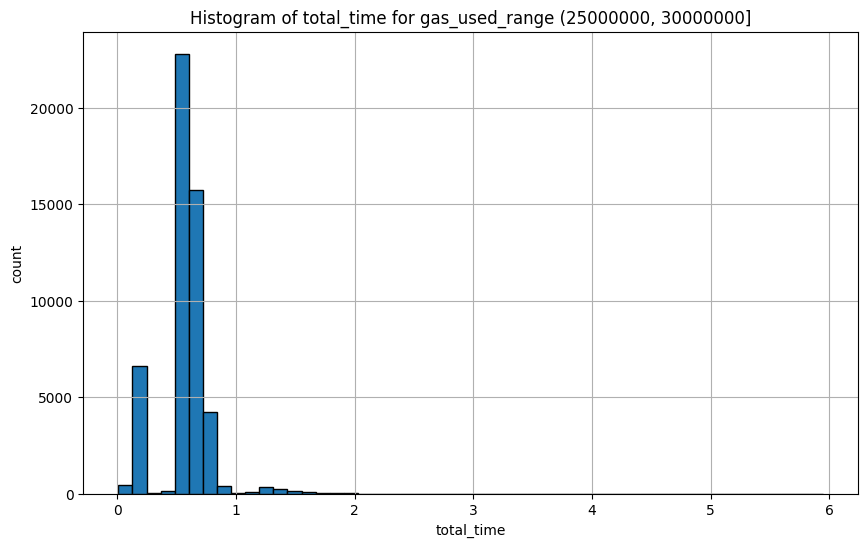

In [8]:
plot_histogram(grouped_reth, distribution_reth.loc[5, 'gas_used_range'])

In [9]:
df_snapshot_archive = load_json('base_snapshot_archive_high_cache.json')
df_snapshot_full = load_json('base_snapshot_full_high_cache.json')

distribution_snapshot_archive, under_1_sec_snapshot_archive, grouped_snapshot_archive = calculate_statistics(df_snapshot_archive)
distribution_snapshot_full, under_1_sec_snapshot_full, grouped_snapshot_full = calculate_statistics(df_snapshot_full)

In [10]:
print(f"op-geth archive node | base-mainnet {min(df_snapshot_archive['block_number'])} ~ {max(df_snapshot_archive['block_number'])} | {under_1_sec_snapshot_archive:.4f}% is under 1s")
distribution_snapshot_archive

op-geth archive node | base-mainnet 13686867 ~ 14990129 | 99.0195% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.088432,1.838,0.086,0.094,0.101,0.107,0.13300,0.18300,72128,99.841948,100.000000
1,"(5000000, 10000000]",0.149834,3.624,0.138,0.159,0.173,0.186,0.21900,0.30100,748754,99.635928,99.967680
2,"(10000000, 15000000]",0.220841,4.264,0.195,0.222,0.245,0.268,0.31300,0.90325,330376,99.061372,99.736664
3,"(15000000, 20000000]",0.342950,5.180,0.263,0.307,0.355,0.402,0.57900,2.26265,85836,96.113519,98.483154
4,"(20000000, 25000000]",0.436108,5.240,0.335,0.402,0.459,0.522,1.07120,2.41900,35999,94.847079,97.680491
5,"(25000000, 30000000]",0.514245,5.299,0.404,0.471,0.539,0.616,1.13355,3.22200,30170,94.540935,96.715280
6,"(0, 30000000]",0.193499,5.299,0.158,0.204,0.243,0.278,0.35100,0.97400,1303263,99.019461,99.674663


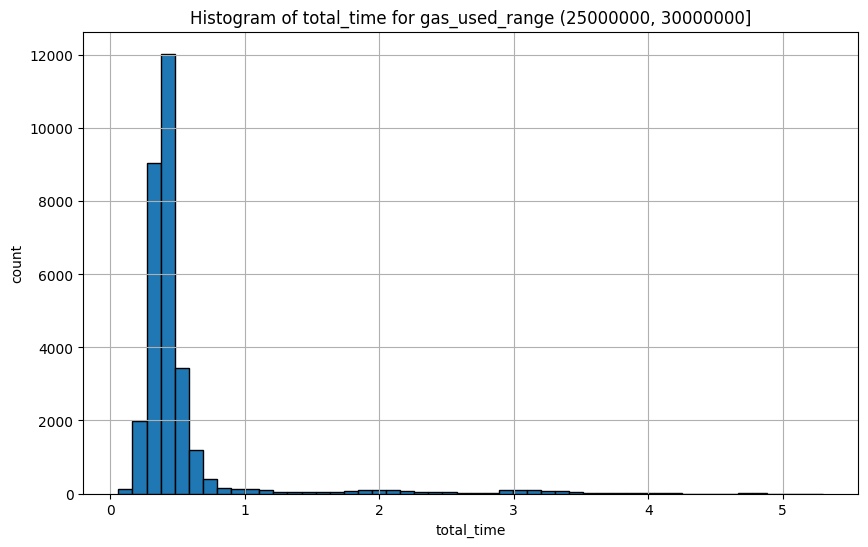

In [11]:
plot_histogram(grouped_snapshot_archive, distribution_snapshot_archive.loc[5, 'gas_used_range'])

In [12]:
print(f"op-geth full node | base-mainnet {min(df_snapshot_full['block_number'])} ~ {max(df_snapshot_full['block_number'])} | {under_1_sec_snapshot_full:.4f}% is under 1s")
distribution_snapshot_full

op-geth full node | base-mainnet 14567037 ~ 14990129 | 99.7109% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.087173,0.816,0.083,0.091,0.097,0.113,0.1440,0.17300,30826,100.000000,100.000000
1,"(5000000, 10000000]",0.137754,2.670,0.129,0.149,0.162,0.178,0.2160,0.27400,234648,99.976134,99.999148
2,"(10000000, 15000000]",0.199350,4.984,0.182,0.208,0.230,0.260,0.3040,0.45000,104729,99.741237,99.984722
3,"(15000000, 20000000]",0.278504,4.902,0.240,0.278,0.319,0.359,0.4460,1.29205,28980,98.347136,99.917184
4,"(20000000, 25000000]",0.340182,3.160,0.306,0.347,0.384,0.438,0.5415,1.22930,13471,97.928884,99.925766
5,"(25000000, 30000000]",0.378001,2.773,0.352,0.401,0.448,0.499,0.5841,1.05724,10439,98.678034,99.952103
6,"(0, 30000000]",0.171329,4.984,0.148,0.193,0.230,0.264,0.3230,0.51600,423093,99.710938,99.986528


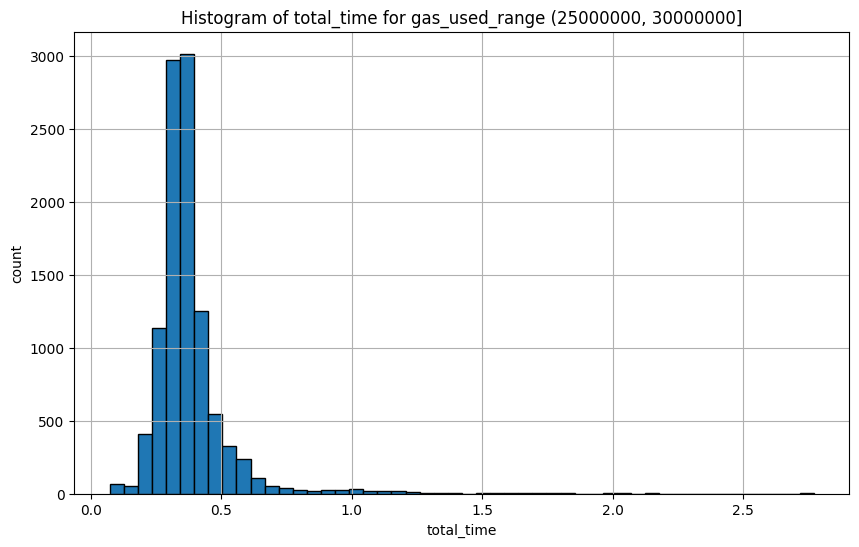

In [13]:
plot_histogram(grouped_snapshot_full, distribution_snapshot_full.loc[5, 'gas_used_range'])